## Predicting house prices: a regression example

* Predicting a continuous value instead of a discrete label

> ### The Boston Housing Price dataset

regression 문제이다 어떻게하는지 알아보고 데이터개수가 좀 작은데 작을때 어떻게 할지에 대해서도 알아볼것이다

* We want to predict the median price of homes in a given Boston suburb in the mid-1970s, given the crime rate, the local property tax rate, and so on.
* It has relatively few data points: only 506 (404 training samples and 102 test samples).
* Each feature in the input has a different scale.
  * For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, and so on.

In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

> ### Preparing the data

* It would be problematic to feed into a neural network values that all take wildly different ranges.
* Let's do feature-wise normalization
  * For each feature, we subtract the mean of the feature and divide by the standard deviation.
  * Then, the feature is centered around 0 and has a unit standard deviation.

In [6]:
mean = train_data.mean(axis=0) # 첫번째 axis에 대해서 평균을 구하는것
std = train_data.std(axis=0) # 똑같다

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std
## 여기서 아주 중요하게 봐야하는건 test_data를 train_data의 평균과 std로 나눴다는것이다. 
## test_data도 평균과 표편이 있는데 절대 그러면 안된다.

In [8]:
mean

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

그냥 normalize하는거다 scaling하는것

* Note that the quantities used for normalizing the test data are computed using the training data.
* NEVER use any quantity computed on the test data, even for something as simple as data normalization.

> ### Building the network

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1)) #output layer의 activation function이 없다 값이 나와야하기때문에 확률로 변환시킬 필요가 없다
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

* This network ends with a single unit and no activation (it is called a linear layer).
* `mse` loss 
  * mean squared error, the square of the difference between the predictions and the targets
* `mae` for monitoring
  * mean absolute error, the absolute error of the difference between the predictions and the targets

> ### Validation with k-fold cross validation technique

데이터의 개수가 너무 작다 valid데이터를 뚝 떼버리면 300개로 training해야하는데 너무 값이 작아버린다.<br>
표본이 작으니까 3개의 데이터 train valid test가 어떻게 되냐에 따라 값의 차이가 커질것이다<br>
보통 그럴때 가장 많이 사용하는 방법은 k-fold cross validation 방법이다<br>
train_data를 k만큼 분할을 하고 하나의 set을 val 나머지는 train으로 여러번 반복해서 accuracy를 높히는 방법

* Since we have few data points, the validation set would be very small if we randomly split the data into a training set and a validation set.
  * It means that the validation scores might change a lot depending on which data points we chose for the validation.
  * We can say that the validation scores might have a high *variance* with regard to the validation split.
  
* The best practice in such situations is to use *k-fold cross-validation*.
  * It consists of splitting the available data into *k* partitions, instantiating *k* identical models, and training each one of *k-1* partitions while evaluating on the remaining partition.
  * The validation score for the model used is then the average of the *k* validation scores obtained.
  
  <img src="https://drive.google.com/uc?id=13ND0yDLHrn1GmDKJ1TjVg21jbeji8DAt" width="800">




In [9]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 300
all_mae_histories = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
  
  partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                       train_data[(i+1)*num_val_samples:]],
                                      axis=0)
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                          train_targets[(i+1)*num_val_samples:]],
                                         axis=0)
  
  model = build_model()
  history = model.fit(partial_train_data, 
                      partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs,
                      batch_size=16, 
                      verbose=0) # training하는 과정을 보여주지 않겠다#
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

* Plotting validation scores

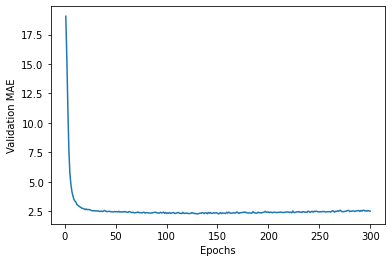

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

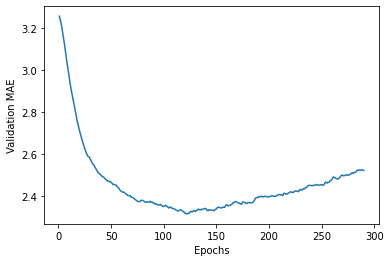

In [12]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

> ### Exercise

* We found that validation MAE stops improving at a some point.
* Write a code to train a final production model on all of the training data and then look at its performance on the test data.